GAT（Graph Attention Networks）2018年提出,是一种专为处理图结构数据而设计的特殊神经网络。

# 图神经网络层
GAT的背后的逻辑就一些节点是比另一节点重要。其实这个思想在GCN（图卷积层）中就已经存在，邻居较少的节点比其他节点更重要，但是这种方法的局限性在于它只考虑了节点的度（degree）。图注意力层的目标是产生不仅考虑了节点的度，还考虑了节点特征重要性的权重因子。


计算节点i和j之间的注意力分数(attention scores):αij

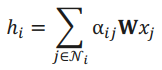


## 主要分为以下几个步骤：

### 1、线性变换(Linear transformation)

- 隐藏向量的拼接：节点i和j之间的隐藏向量会被拼接在一起
- 线性变换：拼接后的向量会通过一个共享的权重矩阵,得到新的隐藏向量
- 注意力分数的计算：对线性变换后的结果应用另一个专门的可学习权重矩阵Watt,得到注意力分数的原始值

### 2、激活函数(Activation function)

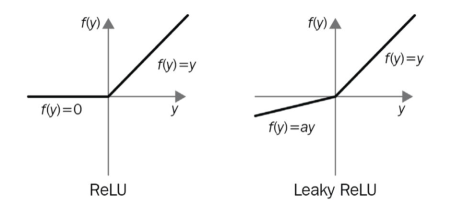

- 通过一个非线性激活函数（如ReLU）来处理得到注意力分数的原始值,得到最终的注意力分数αij,但是此时的值是没有归一化的！

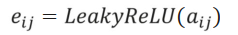

### 3、Softmax归一化(Softmax normalization)

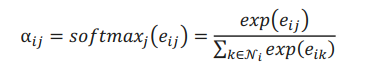

到目前，我们就得到了最终的注意力分数αij,但是有一个问题，自注意力不是非常的稳定！

### 4、多头注意力(Multi-head attention)

这个问题在2017年的Transformer论文中就已经被注意到了，他们提出的解决方案是计算多个具有各自注意力分数的嵌入向量，也就是多头注意力（multi-head attention）。所有的注意力头的结果会被平均或者拼接起来，以得到最终的节点嵌入。这样做的好处是，每个注意力头可以关注到不同的特征或者模式，从而使得GAT能够捕捉到更多的信息。

实现多头注意力只需要多次重复之前的三个步骤。结合多头注意力的方式主要有两种：

- 并行连接（Concatenation）：将每个注意力头产生的嵌入向量首尾相连拼接起来，形成一个更长的向量。然后，这个拼接后的向量通常会通过一个线性变换（也就是另一个权重矩阵）来产生最终的输出。这种方法的好处是它保留了所有注意力头的信息，允许模型在不同的表示子空间中捕捉到不同的特征。

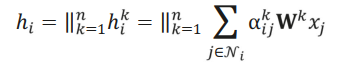

- 平均汇聚（Averaging）：另一种方法是对所有注意力头产生的嵌入向量进行平均。这可以看作是一种减少参数数量并降低过拟合风险的方法。通过平均，模型输出的嵌入向量是所有头输出的加权平均，这样做可以平滑不同头之间的信息，减少模型对特定头的依赖。

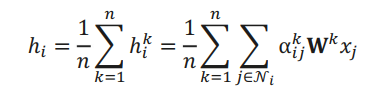

那么使用哪一种方法呢？

在实践中，有一个简单的规则来决定使用哪种方法，当是隐藏层时，选择并行连接的方案；当是网络的最后一层时，选择平均汇聚的方案。

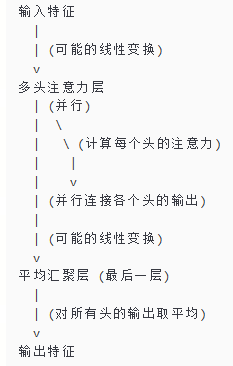

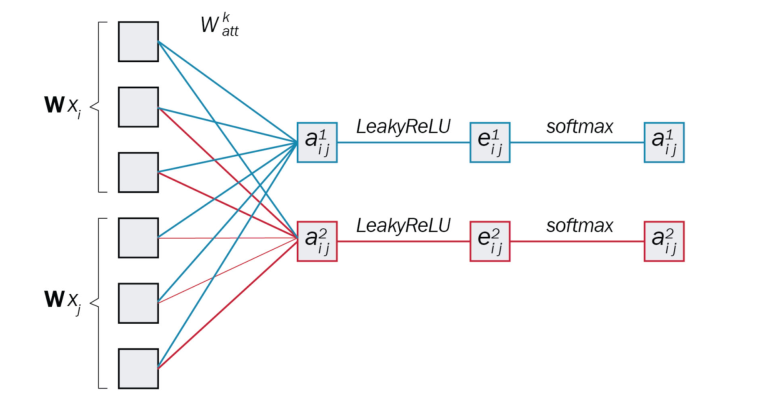


## 例子

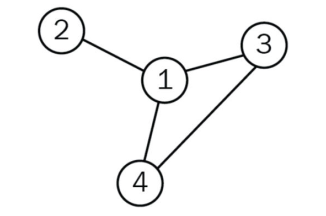

图必须提供两个重要的信息：邻接矩阵(需要带有self-loops)、节点特征


In [2]:
import numpy as np
np.random.seed(0)
#(1)定义邻接矩阵
A = np.array([
[1, 1, 1, 1],
[1, 1, 0, 0],
[1, 0, 1, 1],
[1, 0, 1, 1]
])

In [3]:
A

array([[1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 1, 1]])

In [4]:
#（2）定义特征矩阵
X = np.random.uniform(-1,1,(4,4))
X

array([[ 0.09762701,  0.43037873,  0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823, -0.12482558,  0.783546  ],
       [ 0.92732552, -0.23311696,  0.58345008,  0.05778984],
       [ 0.13608912,  0.85119328, -0.85792788, -0.8257414 ]])

In [5]:
#（3）定义权重矩阵
#在图注意力层中，有两个权重矩阵：常规权重矩阵和注意力权重矩阵。
#有多种初始化权重矩阵的方法，但在这个例子中，我们简单地使用随机函数初始化
#在设计权重矩阵时，需要注意维度，维度是 (ℎ, F)，h表示隐藏层的神经元数量，F表示节点数
W = np.random.uniform(-1,1,(2,4))
W

array([[-0.95956321,  0.66523969,  0.5563135 ,  0.7400243 ],
       [ 0.95723668,  0.59831713, -0.07704128,  0.56105835]])

In [6]:
#（4）定义注意力矩阵
#之前有提到，注意力权重矩阵是应用于每个节点的隐藏向量会与其邻居节点的隐藏向量进行拼接（concatenation），然后产生一个独特的值
# 所以注意力矩阵的维度是(1, dim_ℎ × 2)
W_att = np.random.uniform(-1, 1, (1, 4))
W_att

array([[-0.76345115,  0.27984204, -0.71329343,  0.88933783]])

In [7]:
#（5）拼接节点i和节点j的隐藏向量
#首先查找节点i和j之间的连接 （使用COO格式储存，行是源节点，列是目标节点）
connections = np.where(A > 0)
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

In [8]:
#(6)向量拼接
#将目标节点和源节点的隐藏层的向量拼接起来
np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1) 

array([[ 0.37339233,  0.38548525,  0.37339233,  0.38548525],
       [ 0.37339233,  0.38548525,  0.85102612,  0.47765279],
       [ 0.37339233,  0.38548525, -0.67755906,  0.73566587],
       [ 0.37339233,  0.38548525, -0.65268413,  0.24235977],
       [ 0.85102612,  0.47765279,  0.37339233,  0.38548525],
       [ 0.85102612,  0.47765279,  0.85102612,  0.47765279],
       [-0.67755906,  0.73566587,  0.37339233,  0.38548525],
       [-0.67755906,  0.73566587, -0.67755906,  0.73566587],
       [-0.67755906,  0.73566587, -0.65268413,  0.24235977],
       [-0.65268413,  0.24235977,  0.37339233,  0.38548525],
       [-0.65268413,  0.24235977, -0.67755906,  0.73566587],
       [-0.65268413,  0.24235977, -0.65268413,  0.24235977]])

In [10]:
#(7)使用注意力矩阵对这一结果应用线性变换
#一旦通过拼接源节点和目标节点的隐藏向量得到了一个联合表示，接下来的步骤通常是将这个联合表示通过一个线性变换，以便为注意力分数的计算做好准备。
a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X@ W.T)[connections[1]]], axis=1).T
a

array([[-0.1007035 , -0.35942847,  0.96036209,  0.50390318, -0.43956122,
        -0.69828618,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

In [11]:
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

In [12]:
#(8)使用激活函数
#f(x) = x if x > 0 else alpha * x。
#当输入 x 为负时，Leaky ReLU的斜率就是 alpha，这意味着函数在负值区域不会完全“死亡”（0），而是以一个较小的斜率增长，从而允许梯度流动并保持神经元的活性。
# alpha是负斜率系数
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x, x) 
e = leaky_relu(a)
e

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318, -0.08791224,
        -0.13965724,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

In [13]:
#(9)将这些值放在正确的矩阵中
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]
E

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318],
       [-0.08791224, -0.13965724,  0.        ,  0.        ],
       [ 0.79964181,  0.        ,  1.8607074 ,  1.40424849],
       [ 0.64260322,  0.        ,  1.70366881,  1.2472099 ]])

In [14]:
A

array([[1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 1, 1]])

In [15]:
#(10)归一化每行的注意力分数（将注意力分数转换为概率分布）
#标准的softmax函数是针对整个向量或矩阵进行操作的，但在注意力机制中，我们通常需要对每一行（而不是整个矩阵）单独进行归一化。因此，我们需要一个自定义的softmax函数，它只对每一行的分数进行归一化处理。
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis),
    axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum
W_alpha = softmax2D(E, 1)

In [16]:
W_alpha

array([[0.15862414, 0.15062488, 0.42285965, 0.26789133],
       [0.24193418, 0.22973368, 0.26416607, 0.26416607],
       [0.16208847, 0.07285714, 0.46834625, 0.29670814],
       [0.16010498, 0.08420266, 0.46261506, 0.2930773 ]])

In [17]:
#（11）注意力矩阵 α 为网络中的每种可能连接提供了权重，我们可以使用它来计算embedding矩阵
H = A.T @ W_alpha @ X @ W.T
H

array([[-1.10126376,  1.99749693],
       [-0.33950544,  0.97045933],
       [-1.03570438,  1.53614075],
       [-1.03570438,  1.53614075]])